# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Análise e Previsão de Séries Temporais com Inteligência Artificial</font>

## <font color='blue'>Estudo de Caso 2</font>
### <font color='blue'>IA com Modelo Transformer Para Análise e Forecast de Séries Temporais com Dados de Vendas</font>

![DSA](imagens/EC2.png)

## Instalando e Carregando os Pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
# !pip install -q -U watermark

In [3]:
!pip install -q torch==2.0.0

In [4]:
# Imports
import torch
import sklearn
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

sklearn: 1.2.2
pandas : 1.5.3
torch  : 2.0.0
numpy  : 1.22.4



## Carregando os Dados

In [6]:
# Carrega os dados
arquivo = "dados/dataset.csv"
dados_vendas = pd.read_csv(arquivo, usecols = [1], engine = 'python')

In [7]:
# Shape
dados_vendas.shape

(144, 1)

In [8]:
# Amostra dos dados
dados_vendas.head()

Unidades_Vendidas
0                112
1                118
2                132
3                129
4                121

<Axes: >

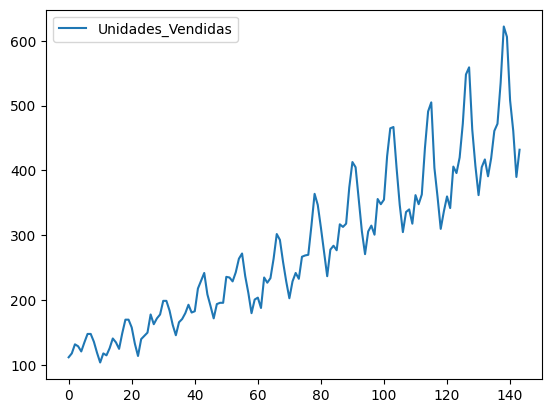

In [9]:
# Plot
dados_vendas.plot()

In [10]:
# Converte os dados para float32 a fim de melhorar a precisão dos cálculos
dataset = dados_vendas.values.astype('float32')

In [11]:
# Amostra dos dados
dataset[0:5]

array([[112.],
       [118.],
       [132.],
       [129.],
       [121.]], dtype=float32)

## Pré-Processamento dos Dados

In [12]:
# Cria o padronizador
scaler = MinMaxScaler(feature_range = (0, 1))

Esta linha de código acima cria um objeto MinMaxScaler do scikit-learn para normalizar (ou escalar) os valores de um conjunto de dados. O objetivo é transformar os valores das características (features) para um intervalo específico, neste caso, entre 0 e 1.

In [13]:
# Fit e transform nos dados
dataset = scaler.fit_transform(dataset)

O método fit_transform() é um método do objeto MinMaxScaler que realiza duas etapas em uma única chamada de função. Primeiro, ajusta (fit) o scaler aos dados fornecidos, calculando o valor mínimo e máximo de cada característica no conjunto de dados. Em seguida, transforma os dados, reescalando cada valor das características.

In [14]:
len(dataset)

144

In [15]:
# Divide os dados em amostras de treino e teste seguindo a ordem dos dados no conjunto de dados
tamanho_treino = int(len(dataset) * 0.67)
test_size = len(dataset) - tamanho_treino
dados_treino, dados_teste = dataset[0:tamanho_treino], dataset[tamanho_treino:]

In [16]:
len(dados_treino)

96

In [17]:
len(dados_teste)

48

> Agora separamos dados de entrada e saída.

In [18]:
# Função para criar os datasets de treino e teste
def create_dataset(data, window_size):
    
    # Listas de X e Y
    X, Y = [], []
    
    # Loop para criar X (11 elementos) e Y (1 elemento)
    for i in range(len(data) - window_size - 1):
        a = data[i:(i + window_size), 0]
        X.append(a)
        Y.append(data[i + window_size, 0])
    
    return np.array(X), np.array(Y)

In [19]:
# Tamanho da janela
window_size = 12

In [20]:
# Cria os datasets de treino e teste
X_treino, Y_treino = create_dataset(dados_treino, window_size)
X_teste, Y_teste = create_dataset(dados_teste, window_size)

In [21]:
X_treino

array([[0.01544401, 0.02702703, 0.05405405, 0.04826255, 0.03281853,
        0.05984557, 0.08494207, 0.08494207, 0.06177607, 0.02895753,
        0.        , 0.02702703],
       [0.02702703, 0.05405405, 0.04826255, 0.03281853, 0.05984557,
        0.08494207, 0.08494207, 0.06177607, 0.02895753, 0.        ,
        0.02702703, 0.02123553],
       [0.05405405, 0.04826255, 0.03281853, 0.05984557, 0.08494207,
        0.08494207, 0.06177607, 0.02895753, 0.        , 0.02702703,
        0.02123553, 0.04247104],
       [0.04826255, 0.03281853, 0.05984557, 0.08494207, 0.08494207,
        0.06177607, 0.02895753, 0.        , 0.02702703, 0.02123553,
        0.04247104, 0.07142857],
       [0.03281853, 0.05984557, 0.08494207, 0.08494207, 0.06177607,
        0.02895753, 0.        , 0.02702703, 0.02123553, 0.04247104,
        0.07142857, 0.05984557],
       [0.05984557, 0.08494207, 0.08494207, 0.06177607, 0.02895753,
        0.        , 0.02702703, 0.02123553, 0.04247104, 0.07142857,
        0.05984557,

In [22]:
Y_treino

array([0.02123553, 0.04247104, 0.07142857, 0.05984557, 0.04054055,
       0.08687258, 0.12741312, 0.12741312, 0.10424709, 0.05598456,
       0.01930502, 0.06949806, 0.07915059, 0.08880308, 0.14285713,
       0.11389962, 0.13127413, 0.14285713, 0.18339768, 0.18339768,
       0.15444016, 0.11196911, 0.08108109, 0.1196911 , 0.12934363,
       0.14671814, 0.17181468, 0.14864865, 0.15250966, 0.22007722,
       0.24324325, 0.26640925, 0.2027027 , 0.16795367, 0.13127413,
       0.17374519, 0.17760617, 0.17760617, 0.25482625, 0.25289574,
       0.24131274, 0.26833975, 0.3088803 , 0.32432434, 0.25675675,
       0.20656371, 0.14671814, 0.18725869, 0.19305018, 0.16216215,
       0.25289574, 0.23745173, 0.25096524, 0.3088803 , 0.38223937,
       0.36486486, 0.2992278 , 0.24131274, 0.1911197 , 0.24131274,
       0.26640925, 0.24903473, 0.31467178, 0.3185328 , 0.32046333,
       0.4073359 , 0.5019305 , 0.46911195, 0.40154442, 0.32818535,
       0.25675675, 0.3359073 , 0.34749034, 0.33397684, 0.41119

In [23]:
# Converte tudo de array NumPy para tensor PyTorch
X_treino = torch.from_numpy(X_treino).float()
Y_treino = torch.from_numpy(Y_treino).float()
X_teste = torch.from_numpy(X_teste).float()
Y_teste = torch.from_numpy(Y_teste).float()

## Construção dos Data Loaders

In [24]:
# Classe para criação do dataset da série temporal
class TimeSeriesDataset(Dataset):
    
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [25]:
# Cria os TimeSeriesDatasets
train_dataset = TimeSeriesDataset(X_treino, Y_treino)
test_dataset = TimeSeriesDataset(X_teste, Y_teste)

In [26]:
# Cria os dataloaders
train_loader = DataLoader(train_dataset, batch_size = 1, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

## Construção do Modelo Transformer

![DSA](imagens/transformer.png)

https://arxiv.org/abs/1706.03762

https://www.deeplearningbook.com.br/como-funcionam-os-transformadores-em-processamento-de-linguagem-natural-parte-1/

Esta é uma classe chamada TimeSeriesTransformer que herda de nn.Module, o que significa que é um módulo personalizado do PyTorch. Essa classe implementa um modelo transformer para lidar com séries temporais. 

O método construtor inicializa a classe TimeSeriesTransformer e define seus componentes principais. Ele recebe cinco argumentos:

- input_dim: a dimensão das características de entrada.
- model_dim: a dimensão do modelo do transformer (também chamado de d_model).
- num_heads: o número de cabeças de atenção no mecanismo de atenção multi-cabeça.
- num_layers: o número de camadas do codificador transformer.
- dropout: uma taxa de dropout aplicada em várias partes do transformer (por padrão, 0.1).

Os componentes principais do TimeSeriesTransformer inicializados no método construtor são:

-  self.embedding: Uma camada linear que converte a dimensão de entrada input_dim para a dimensão do modelo model_dim.

- self.encoder_layer: Uma camada de codificador do transformer, que é um bloco básico do codificador transformer. Esta camada usa a atenção "multi-cabeça" e redes feedforward.

- self.transformer_encoder: O codificador do transformer completo, que empilha várias camadas do codificador definidas em num_layers.

- self.linear: Uma camada linear que mapeia a saída do transformer para a dimensão de saída desejada (em nosso caso, 1).

O método forward define a passagem direta (forward pass) do modelo TimeSeriesTransformer. Ele recebe um tensor x como entrada e retorna a saída do modelo. As etapas da passagem direta são:

- x = self.embedding(x): Aplica a camada de incorporação (embedding) para converter a dimensão das características de entrada para a dimensão do modelo.

- x = x.permute(1, 0, 2): Reorganiza o tensor x de (batch, sequence, feature) para (sequence, batch, feature), já que o transformer espera essa disposição de dimensões.

- x = self.transformer_encoder(x): Passa o tensor x através do codificador do transformer.

- x = self.linear(x): Aplica a camada linear para mapear a saída do transformer para a dimensão de saída desejada.

- x = x.permute(1, 0, 2): Reorganiza o tensor x de volta para (batch, sequence, feature).

- return x[:, -1, :]: Retorna a última saída da sequência para cada amostra no batch. Isso é feito para obter a previsão de um único passo à frente.

In [27]:
# Cria a classe do modelo
class TimeSeriesTransformer(nn.Module):
    
    # Método construtor
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout = 0.1):
        
        super().__init__()
        
        self.embedding = nn.Linear(input_dim, model_dim)
        
        self.encoder_layer = nn.TransformerEncoderLayer(d_model = model_dim, nhead = num_heads, dropout = dropout)
        
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers = num_layers)
        
        self.linear = nn.Linear(model_dim, 1)

    # Método forward
    def forward(self, x):
        
        x = self.embedding(x)
        
        x = x.permute(1, 0, 2)  
        
        x = self.transformer_encoder(x)
        
        x = self.linear(x)
        
        x = x.permute(1, 0, 2)
        
        return x[:, -1, :]

**Atenção é Tudo Que Você Precisa**

A camada de auto-atenção em um modelo Transformer é uma parte fundamental da arquitetura, responsável por identificar e ponderar as relações entre os elementos em uma sequência. Essa camada permite que o modelo capte as dependências entre os elementos, independentemente de suas posições na sequência, e aprenda padrões contextuais relevantes.

O mecanismo de auto-atenção funciona calculando a similaridade entre todas as combinações dos elementos em uma sequência, utilizando os embeddings (matrizes) como entrada. Essa similaridade é então transformada em pesos de atenção, que indicam o grau de relevância entre os elementos. Os pesos de atenção são multiplicados pelos embeddings para produzir uma representação ponderada da sequência.

## Hiperparâmetros, Função de Erro e Otimizador

In [28]:
# Hiperparâmetros
input_dim = 1
model_dim = 64
num_heads = 4
num_layers = 2
taxa_aprendizado = 0.001

In [29]:
# Cria o modelo
model = TimeSeriesTransformer(input_dim, model_dim, num_heads, num_layers)

In [30]:
# Função de perda
criterion = nn.MSELoss()

Esta linha de código acima cria uma instância do objeto nn.MSELoss() da biblioteca PyTorch e atribui à variável criterion. 

nn.MSELoss() é uma função de perda (loss function) que calcula o erro quadrático médio (MSE, Mean Squared Error) entre a saída prevista pelo modelo e o valor real (rótulo).

O erro quadrático médio é uma medida comumente usada para avaliar a qualidade das previsões em problemas de regressão, como a previsão de séries temporais. 

In [31]:
# Otimizador
optimizer = optim.Adam(model.parameters(), lr = taxa_aprendizado)

Esta linha de código acima cria uma instância do otimizador optim.Adam da biblioteca PyTorch e atribui à variável optimizer. O otimizador Adam é um algoritmo popular de otimização baseado em gradientes para treinamento de modelos de aprendizado de máquina, como redes neurais.

Vamos analisar cada parte do código:

**optim.Adam**: É uma classe do PyTorch que implementa o algoritmo de otimização Adam (Adaptive Moment Estimation). O algoritmo Adam combina os conceitos de momento e taxa de aprendizado adaptativa para fornecer uma convergência mais rápida e eficiente em comparação com outros algoritmos de otimização baseados em gradientes, como o Gradiente Descendente Estocástico (SGD).

**model.parameters()**: É uma função que retorna um iterador sobre os parâmetros (pesos e vieses) do modelo que serão otimizados. No contexto desta linha de código, model é uma instância do modelo (por exemplo, a classe TimeSeriesTransformer explicada anteriormente) que você deseja treinar.

**lr = taxa_aprendizado**: É um parâmetro que define a taxa de aprendizado (learning rate) do algoritmo de otimização. A taxa de aprendizado é um hiperparâmetro que controla o tamanho dos ajustes nos parâmetros do modelo durante o processo de otimização. Um valor menor de taxa de aprendizado resulta em atualizações menores dos parâmetros, levando a uma convergência mais lenta, enquanto um valor maior pode resultar em uma convergência mais rápida, mas também pode causar instabilidade e impedir que o modelo encontre a solução ótima.

Durante o treinamento do modelo, o otimizador será usado para atualizar os parâmetros do modelo com base nos gradientes calculados a partir da função de perda (por exemplo, nn.MSELoss()), com o objetivo de minimizar a perda e melhorar a qualidade das previsões do modelo.

## Loop de Treino

In [32]:
# Função para o loop de treino
def treina_modelo(model, train_loader, criterion, optimizer, num_epochs = 50):
    
    # Coloca o modelo em modo de treino
    model.train()
    
    # Loop pelo número de épocas
    for epoch in range(num_epochs):
        
        # Inicializa o erro
        running_loss = 0.0
        
        # Loop pelos dados
        for i, (inputs, labels) in enumerate(train_loader):
            
            # Ajusta o shape da entrada e da saída
            inputs = inputs.unsqueeze(-1)
            labels = labels.unsqueeze(-1)

            # Zera os gradientes
            optimizer.zero_grad()

            # Faz as previsões
            outputs = model(inputs)
            
            # Calcula o erro
            loss = criterion(outputs, labels)
            
            # Aplica o backpropagation
            loss.backward()
            optimizer.step()

            # Calcula o erro
            running_loss += loss.item()
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Erro: {running_loss / len(train_loader)}")

In [33]:
# Treina o modelo
treina_modelo(model, train_loader, criterion, optimizer, num_epochs = 50)

Epoch 1/50, Erro: 0.137725557772828
Epoch 2/50, Erro: 0.026660215387262022
Epoch 3/50, Erro: 0.024937273309966715
Epoch 4/50, Erro: 0.0249391854812843
Epoch 5/50, Erro: 0.017554271803143204
Epoch 6/50, Erro: 0.02226425376403266
Epoch 7/50, Erro: 0.017675605968464198
Epoch 8/50, Erro: 0.01618162832824877
Epoch 9/50, Erro: 0.015756385453887863
Epoch 10/50, Erro: 0.017215309926957918
Epoch 11/50, Erro: 0.018069826444197277
Epoch 12/50, Erro: 0.016000167054782532
Epoch 13/50, Erro: 0.013893514555367078
Epoch 14/50, Erro: 0.01870415112495381
Epoch 15/50, Erro: 0.021670130588477672
Epoch 16/50, Erro: 0.01956514193525217
Epoch 17/50, Erro: 0.01743632910930057
Epoch 18/50, Erro: 0.01540207052561067
Epoch 19/50, Erro: 0.015377858412028737
Epoch 20/50, Erro: 0.017732776642618093
Epoch 21/50, Erro: 0.02095738458290243
Epoch 22/50, Erro: 0.021175480386683015
Epoch 23/50, Erro: 0.018756741862478478
Epoch 24/50, Erro: 0.019686418980590672
Epoch 25/50, Erro: 0.01749138402309935
Epoch 26/50, Erro: 0.0

## Loop de Avaliação

In [34]:
# Função para o loop de avaliação
def avalia_modelo(model, test_loader):
    
    # Coloca o modelo em modo de avaliação
    model.eval()
    
    with torch.no_grad():
        
        total_loss = 0.0
        
        for inputs, labels in test_loader:
            
            inputs = inputs.unsqueeze(-1)
            
            labels = labels.unsqueeze(-1)

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
        
        print(f"Erro em Teste: {total_loss / len(test_loader)}")

A linha **with torch.no_grad():** na célula acima é usada para criar um contexto no qual o PyTorch desativa o rastreamento dos gradientes. Isso significa que, durante a execução do código dentro deste bloco, o PyTorch não armazenará informações sobre as operações realizadas nos tensores, e não calculará nem armazenará os gradientes.

O rastreamento de gradientes é necessário apenas durante a fase de treinamento do modelo, quando os gradientes são usados para atualizar os parâmetros do modelo (pesos e vieses) através de um algoritmo de otimização, como o Adam. No entanto, durante a fase de validação ou teste, não é necessário calcular os gradientes, pois os parâmetros do modelo não são atualizados.

Usar o contexto with torch.no_grad(): tem duas vantagens principais:

- Redução do uso de memória: Ao desativar o rastreamento de gradientes, o PyTorch não armazena informações adicionais sobre as operações realizadas nos tensores, economizando memória.

- Melhoria no desempenho: Como o rastreamento de gradientes é desativado, o PyTorch não precisa calcular e armazenar os gradientes, resultando em um desempenho computacional mais rápido.

Essa linha de código é comumente usada antes de executar o código para avaliar o desempenho do modelo em um conjunto de validação ou teste, ou para fazer inferências e previsões com o modelo treinado.

In [35]:
# Avalia o modelo
avalia_modelo(model, test_loader)

Erro em Teste: 0.08545020420320465


## Forecast com Modelo Transformer

In [36]:
# Função para o forecast (previsão)
def forecast(model, X, num_steps):
    
    model.eval()
    
    preds = []
    
    with torch.no_grad():
        
        for _ in range(num_steps):
            
            X_input = X.unsqueeze(-1).unsqueeze(0)
            
            output = model(X_input)
            
            preds.append(output.item())

            X = torch.cat((X[1:], output.squeeze().unsqueeze(0)), 0)

    return preds

In [37]:
# Janela de previsão
num_steps = 12

In [38]:
# Obtemos os 12 últimos registros dos dados de teste
X_12meses = X_teste[-1]

In [39]:
X_12meses

tensor([0.4981, 0.5811, 0.6042, 0.5541, 0.6081, 0.6892, 0.7104, 0.8320, 1.0000,
        0.9691, 0.7799, 0.6892])

In [40]:
# Fazemos o forecast de 12 passos no temppo (12 meses) a partir dos 12 últimos registros em teste
valores_previstos = forecast(model, X_12meses, num_steps)

In [41]:
valores_previstos

[0.3771977424621582,
 0.37866923213005066,
 0.37867680191993713,
 0.3786854147911072,
 0.37869226932525635,
 0.37869909405708313,
 0.37870514392852783,
 0.3787105679512024,
 0.37870803475379944,
 0.3787086308002472,
 0.3787389397621155,
 0.37876012921333313]

In [42]:
type(valores_previstos)

list

In [43]:
# Converte para array numpy e ajusta o shape
valores_previstos_arr = np.array(valores_previstos).reshape(-1, 1)

In [44]:
type(valores_previstos_arr)

numpy.ndarray

In [45]:
# Invertendo a escala das previsões
previsões_finais = scaler.inverse_transform(valores_previstos_arr)

In [46]:
# Previsão (forecast) para os 12 próximos passos no tempo
previsões_finais

array([[299.3884338 ],
       [300.15066546],
       [300.15458661],
       [300.15904808],
       [300.16259873],
       [300.16613394],
       [300.16926777],
       [300.17207742],
       [300.17076522],
       [300.17107397],
       [300.18677401],
       [300.19775015]])

# Fim